In [4]:
###Light Curve and Gaussian Fit
##It takes long to run
##For every Object we will have to change the period, and the initial guesses manually for the fit to work

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import lightkurve as lk
from scipy.optimize import curve_fit
import pandas as pd

In [5]:
TIC = 'TIC 337646214'

data_all = lk.search_lightcurve(TIC, author='SPOC')

data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 44,2021,SPOC,20,337646214,0.0
1,TESS Sector 45,2021,SPOC,20,337646214,0.0
2,TESS Sector 46,2021,SPOC,20,337646214,0.0
3,TESS Sector 44,2021,SPOC,120,337646214,0.0
4,TESS Sector 45,2021,SPOC,120,337646214,0.0
5,TESS Sector 46,2021,SPOC,120,337646214,0.0
6,TESS Sector 72,2023,SPOC,20,337646214,0.0
7,TESS Sector 72,2023,SPOC,120,337646214,0.0


<IPython.core.display.Javascript object>

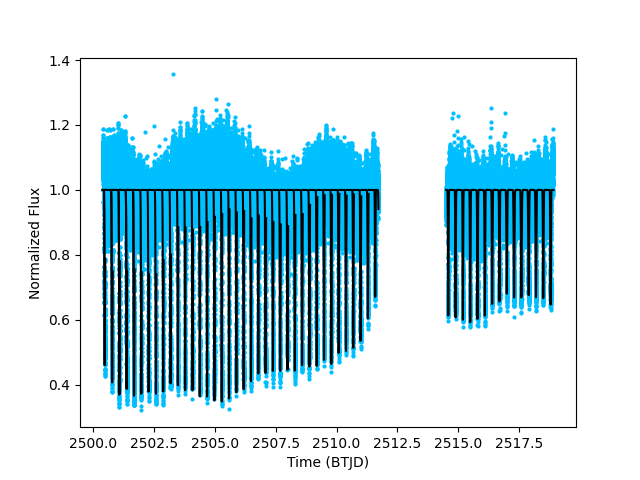

In [6]:
import matplotlib.pyplot as plt

#data = data_all[0]
lc = data_all.download_all().stitch()

# Define the Gaussian function
def gaussian_function(x, A, mu, sigma):
    return -(A * np.exp(-((x - mu)**2) / (2 * sigma**2))-1)

def process_chunk(start_index, end_index, mu_fit):
    Times = lc.time[start_index:end_index]
    t = Time(Times)
    x = np.array(t.btjd)
    y = np.array(lc.flux[start_index:end_index])
    
    # Remove invalid values (infs and NaNs) from y and x arrays
    mask_valid = ~np.isnan(y) & ~np.isinf(y)
    x = x[mask_valid]
    y = y[mask_valid]
    
    while len(x) > 3:
        # Fitting the curve to the data
        initial_guess = [A_guess, mu_fit, sigma_guess]
        params, covariance = curve_fit(gaussian_function, x, y, p0=initial_guess, maxfev=10000)

        # Get fitted values for A, μ and σ
        A_fit, mu_fit, sigma_fit = params

        # Get the diagonals of the covariance matrix as the variances of A, μ and σ
        var_A_fit, var_mu_fit, var_sigma_fit = np.diag(covariance)

        # Create points for the fitted curve
        x_fit = np.linspace(min(x), max(x), 1000)
        y_fit = gaussian_function(x_fit, A_fit, mu_fit, sigma_fit)

        # Calculate the errors as the square root of the variances
        error_A_fit = np.sqrt(var_A_fit)
        error_mu_fit = np.sqrt(var_mu_fit)
        error_sigma_fit = np.sqrt(var_sigma_fit) 
        
        plt.scatter(x, y, linewidth = 0, marker = '.', color = 'deepskyblue')
        plt.plot(x_fit, y_fit, color='k')
        plt.xlabel('Time (BTJD)')
        plt.ylabel('Normalized Flux')
        plt.grid(False)
        
        '''
        print("\nParameters and their errors", i, ":")
        print("A =", A_fit, "+/-", error_A_fit)
        print("mu =", mu_fit, "+/-", error_mu_fit)
        print("Sigma =", sigma_fit, "+/-", error_sigma_fit, "\n")
        '''
        mu_fit_values.append(mu_fit)
        error_mu_fit_values.append(error_mu_fit)

        return mu_fit
    
    if len(x) <= 3:
        mu_guess= 2514.5
        initial_guess = [A_guess, mu_guess, sigma_guess]
        mu_fit = initial_guess[1]

        return mu_fit

# Define initial guesses for A, mu, and sigma
A_guess = 0.675
mu_guess = 2500.47
sigma_guess = 0.1

# Create the initial_guess list
initial_guess = [A_guess, mu_guess, sigma_guess]

# Get the period in julian days
period_julian_days = 0.3007600205719854

# Initialize mu_fit with the initial guess value for mu
mu_fit = initial_guess[1]

# Initialize lists for mu_fit and error_mu_fit values
mu_fit_values = []
error_mu_fit_values = []

# Iterate through the light curve and process chunks of data with the given period
start_index = 0
i=1
while start_index < len(lc) and i < 59:
    end_time = lc.time[start_index] + period_julian_days
    end_index = np.searchsorted(lc.time, end_time, side='right')
    
    # Call process_chunk with the updated mu_fit value
    mu_fit = process_chunk(start_index, end_index, mu_fit)
    mu_fit = mu_fit + period_julian_days
    
    # Update the start_index for the next iteration
    start_index = end_index
    i=i+1 

plt.show()